# Salut !
Ce Notebook est une prémiere aproximation exploratoire aux images satellitaire du projet fil rouge.
Dans ce Notebook:
- Utilisation de la bibliothéque rasterio pour extraire les bandes des images satellitaires.
- Exploration de la taille des images.
- Affichages des images ("true color" images) c.a.d RGB


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image, show
from sklearn import cluster
from osgeo import gdal, gdal_array

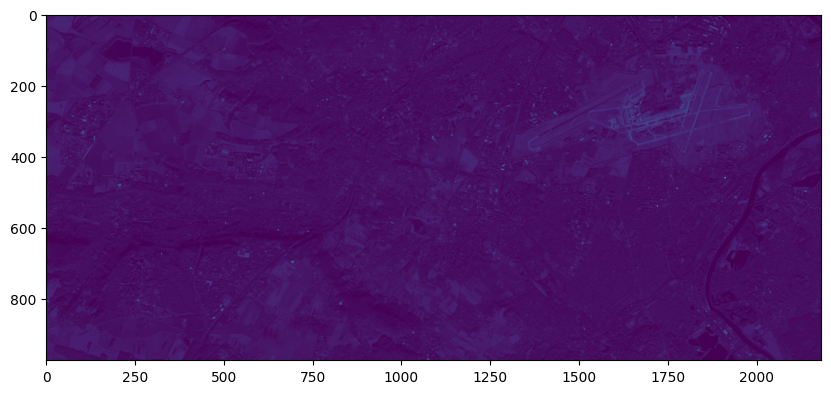

In [2]:
# image_test = cv2.imread("/home/julian/Fil_Rouge/crop_SENTINEL2A_20151226-111142-750_L2A_T31UDQ_D_V1-1.tif")
path_image = "ressources/images/crop_SENTINEL2A_20151226-111142-750_L2A_T31UDQ_D_V1-1.tif"
image_test = cv2.imread(path_image, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(10,10))
plt.imshow(image_test)
plt.show()

In [3]:
with rasterio.open(path_image) as src:
    data = src.read() # gets ALL the data
    single_band = data[0] # gets the first band OR src.read(1)
    
# https://rasterio.readthedocs.io/en/latest/topics/image_processing.html

image = reshape_as_image(data)

print(f'After reshaping as image: {image.shape}')

reshaped_to_raster = reshape_as_raster(image)

print(f'After reshaping as raster: {reshaped_to_raster.shape}')

print('---------------')

print(f'first band, or a single band image: {single_band.shape}')

added_dimension = np.expand_dims(single_band, axis=2)

print(f'After adding a dimension: {added_dimension.shape}')
print('---------------')
print(added_dimension[:,:,0])

After reshaping as image: (973, 2182, 4)
After reshaping as raster: (4, 973, 2182)
---------------
first band, or a single band image: (973, 2182)
After adding a dimension: (973, 2182, 1)
---------------
[[1377 1414 1430 ... 1211 1248  975]
 [1476 1531 1579 ... 1753 1184  730]
 [1579 1657 1666 ... 1176  539  370]
 ...
 [2497 2473 2595 ... 1532  978  933]
 [2564 2544 2518 ... 1160  900  889]
 [2597 2626 2607 ... 1055  862  800]]


In [4]:
src = rasterio.open(path_image)
red = src.read(2)
green = src.read(3)
blue = src.read(4)

print(red.min())
print(red.max())

0
17046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17046


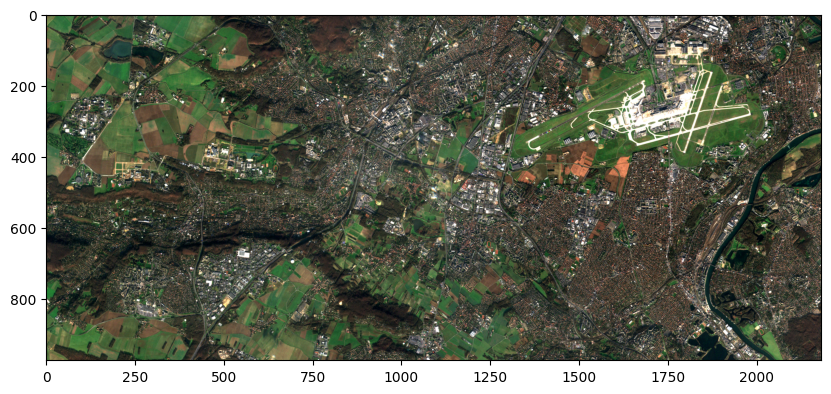

In [5]:
#Taking info from: https://medium.com/artefact-engineering-and-data-science/leveraging-satellite-imagery-for-machine-learning-computer-vision-applications-d22143f72d94

# Changing the intensity of the pixels to obtain a better representation
redn = (red/6).astype(int)
greenn = (green/6).astype(int)
bluen = (blue/6).astype(int)


# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.figure(figsize=(10,10))
plt.imshow(rgb)
print(red.max())

## K-means

In [6]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image 
img_ds = gdal.Open(path_image, gdal.GA_ReadOnly)

band = img_ds.GetRasterBand(3)

img = band.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)

k_means = cluster.KMeans(n_clusters=6)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)

print (len(X_cluster))

(973, 2182)
(2123086, 1)


/home/julian/miniconda3/envs/fil_rouge/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


973


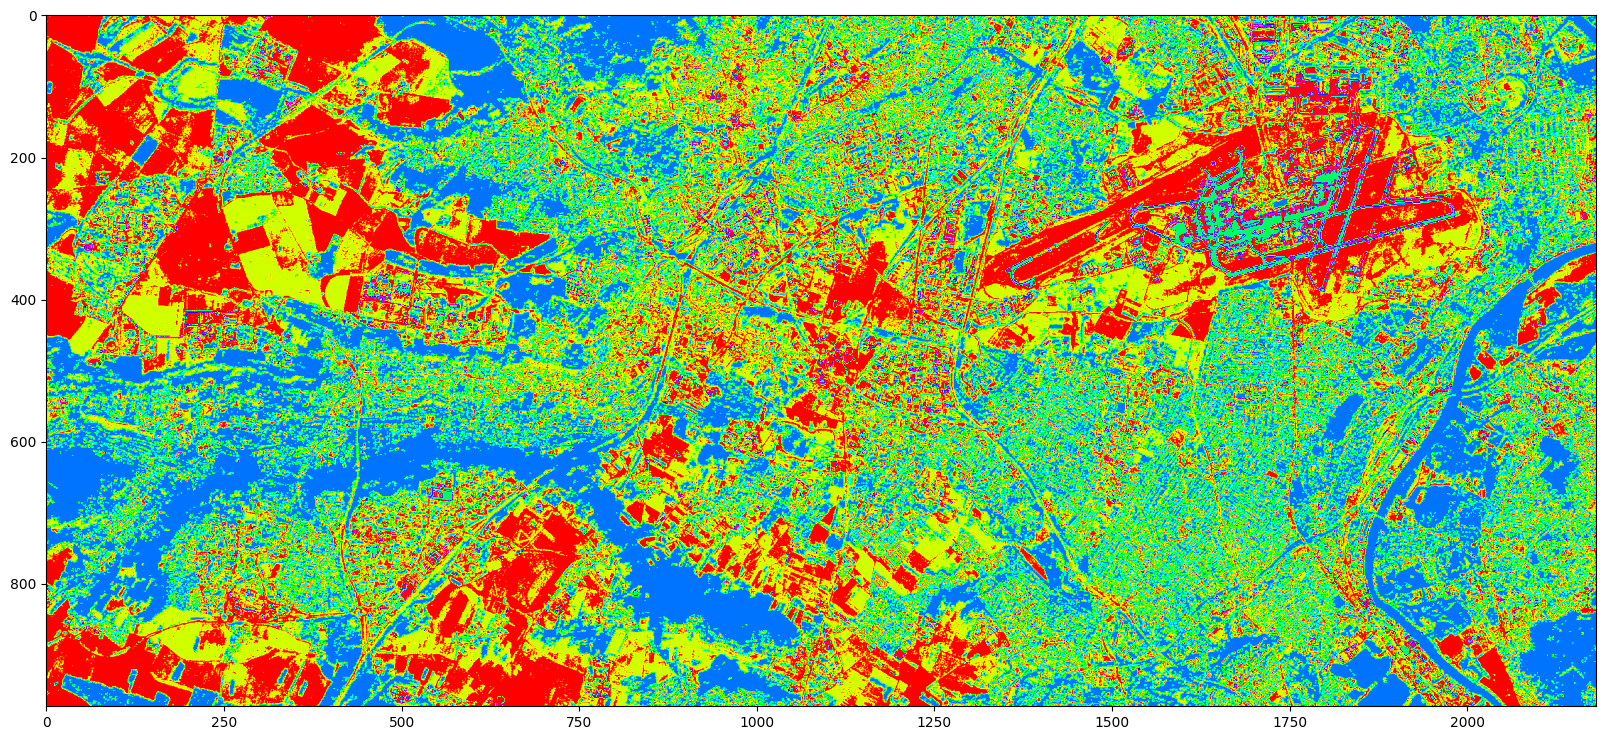

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

In [8]:
img2 = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount-1),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

img2[:, :, 0] = img_ds.GetRasterBand(2).ReadAsArray()
img2[:, :, 1] = img_ds.GetRasterBand(3).ReadAsArray()
img2[:, :, 2] = img_ds.GetRasterBand(4).ReadAsArray()

new_shape = (img2.shape[0] * img2.shape[1], img2.shape[2])
print (img2.shape)
print (new_shape)

X = img2[:, :, :3].reshape(new_shape)

k_means2 = cluster.KMeans(n_clusters=8)
k_means2.fit(X)

X_cluster2 = k_means2.labels_


X_cluster2 = X_cluster2.reshape(img2[:, :, 0].shape)

(973, 2182, 3)
(2123086, 3)


/home/julian/miniconda3/envs/fil_rouge/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(973, 2182)


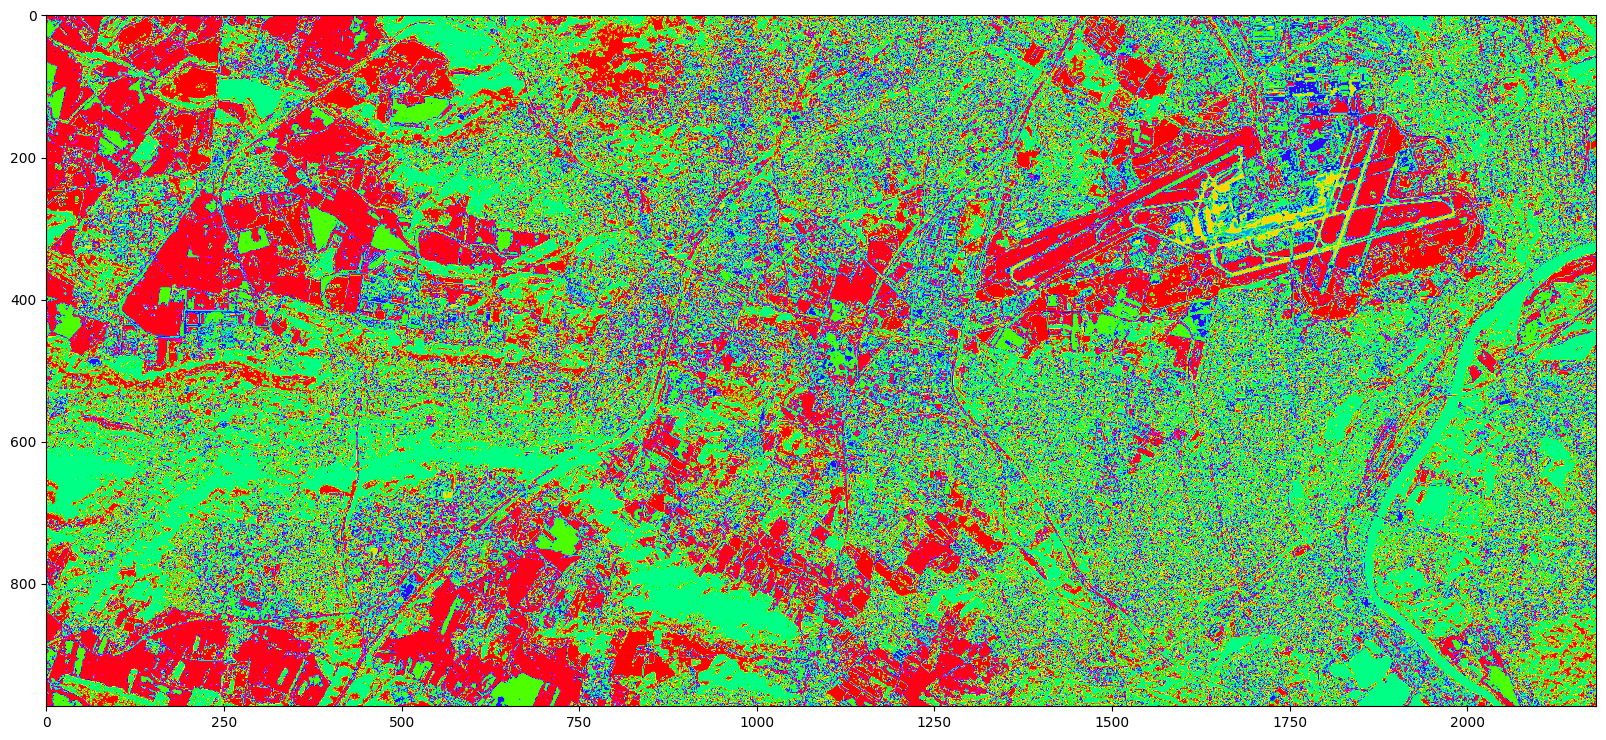

In [9]:
print (X_cluster.shape)

plt.figure(figsize=(20,20))
plt.imshow(X_cluster2, cmap="hsv")

plt.show()